In [1]:
from typing import Dict
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import ellipj, ellipkinc, ellipeinc, ellipk

In [2]:
def calcQ(P: float,bh_mass: float, tol=1e-3) ->float:
    Q=np.sqrt((P - 2.*bh_mass)*(P + 6.*bh_mass))
    return Q

def bfromP(P: float,bh_mass: float, tol: float=1e-5) ->float:
    b = np.sqrt(P**3/(P - 2.*bh_mass))
    return b

def zetainf(P: float,bh_mass: float, tol=1e-6) ->float:
    Q = calcQ(P,bh_mass)
    arg =(Q-P+2.*bh_mass)/(Q-P + 6.*bh_mass)
    z_inf = np.arcsin(np.sqrt(arg))
    return z_inf

def k(P: float,bh_mass: float) ->float:
    Q = calcQ(P,bh_mass)
    k = np.sqrt((Q-P+6*bh_mass)/(2*Q))
    return k

def k2(P: float,bh_mass: float) ->float:
    Q = calcQ(P,bh_mass)
    k2 = (Q-P+6*bh_mass)/(2*Q)
    return k2

def cosgamma(_a: float, incl: float, tol=1e-5) -> float:
    if abs(incl) <tol:
        return 0
    return np.cos(_a)/np.sqrt(np.cos(_a)**2+1/(np.tan(incl)**2))

def eq13(P: float, ir_radius: float,ir_angle: float, bh_mass: float,incl: float, n: int=0, tol=10e-6) -> float:
    z_inf = zetainf(P,bh_mass)
    Q = calcQ(P,bh_mass)
    m_ = k2(P,bh_mass)
    ell_inf = ellipkinc(z_inf,m_)
    g = np.arccos(cosgamma(ir_angle, incl))
    if n:
        ell_k = ellipk(m_)
        ellips_arg = (g-2.*n*np.pi)/(2.*np.sqrt(P/Q))-ell_inf+2.*ell_k
    else:
        ellips_arg=g/(2.*np.sqrt(P/Q)) +ell_inf
    sn,cn,dn,ph = ellipj(ellips_arg, m_)
    sn2 = sn*sn
    term1 = -(Q-P+2.*bh_mass)/(4.*bh_mass*P)
    term2 =((Q-P+6*bh_mass)/(4.*bh_mass*P))*sn2
    return 1.-ir_radius*(term1+term2)

def midpoint_method(func,args:Dict, __x,__y,__ind):
    new_x = __x
    new_y = __y
    x_ = [new_x[__ind],new_x[__ind+1]]
    inbetween_x = np.mean(x_)
    new_x.insert(__ind+1,inbetween_x)
    
    y_ = [new_y[__ind],new_y[__ind+1]]
    inbetween_solution = func(inbetween_x, **args)
    new_y.insert(__ind+1,inbetween_solution)
    y_.insert(1, inbetween_solution)
    ind_of_sign_change_ =np.where(np.diff(np.sign(y_)))[0]
    new_ind=__ind + ind_of_sign_change_[0]
    return new_x, new_y, new_ind

def improve_solutions_midpoint(func, args, x, y, index_of_sign_change, iterations) -> float:
    index_of_sign_change_ = index_of_sign_change
    new_x =x
    new_y =y
    new_ind = index_of_sign_change_
    for iteration in range(iterations):
        new_x, new_y, new_ind = midpoint_method(func=func, args=args, __x=new_x, __y=new_y, __ind = new_ind)
    updated_P = new_x[new_ind]
    return updated_P

def calcP(_r, incl, _alpha, bh_mass, midpoint_iterations =100, plot_inbetween=False, n=0, min_P=1., initial_guesses=20) -> float:
    def get_plot(X,Y,solution, radius=_r):
        fig=plt.figure()
        plt.title("eq13(P)\nr={}, a={}".format(radius, round(_alpha,5)))
        plt.xlabel('P')
        plt.ylabel('Eq13(P)')
        plt.axhline(0,color='black')
        plt.plot(X,Y)
        plt.scatter(solution, 0, color='red')
        return plt
    periastron_range =list(np.linspace(min_P, 2.*_r, initial_guesses))
    y_ = [eq13(P_value, _r,_alpha, bh_mass, incl, n) for P_value in periastron_range]
    ind=np.where(np.diff(np.sign(y_)))[0]
    periastron_solution = periastron_range[ind[0]] if len(ind) else None
    if(periastron_solution is not None) and (not np.isnan(periastron_solution)):
        args_eq13 ={"ir_radius":_r, "ir_angle":_alpha, "bh_mass":bh_mass, "incl":incl, "n":n}
        periastron_solution = \
        improve_solutions_midpoint(func=eq13, args=args_eq13, x=periastron_range,y=y_, index_of_sign_change=ind[0], iterations = midpoint_iterations)
    if plot_inbetween:
        get_plot(periastron_range, y_, periastron_solution).show
    return periastron_solution

def ellipse(r,a,incl):
    g=np.arccos(cosgamma(a,incl))
    b_=r*np.sin(g)
    return b_

def calcb(_r, incl, _alpha, bh_mass, midpoint_iterations, plot_inbetween, n, min_P, initial_guesses) -> float:
    periastron_solution = calcP(_r,incl,_alpha,bh_mass, midpoint_iterations, plot_inbetween,n,min_P,initial_guesses)
    if periastron_solution is None or periastron_solution <=2.*bh_mass:
        return ellipse(_r, _alpha,incl)
    elif periastron_solution >2.*bh_mass:
        b=bfromP(periastron_solution, bh_mass)
        return b
    else:
        raise ValueError("no solution was found for P ar (r,a)=({_r}, {_alpha}) and incl = {incl}")

In [3]:
def fluxeq(radius, angle, incl, bh_mass, midpoint_iterations, plot_inbetween, n, min_P, initial_guesses, f):
    b = calcb(radius, incl, angle, bh_mass, midpoint_iterations, plot_inbetween,n,min_P, initial_guesses)
    return (1-3.*bh_mass/radius)**2*(np.sqrt(radius)-np.sqrt(6)+(np.log((np.sqrt(radius)+np.sqrt(3))*(np.sqrt(6)-np.sqrt(3))/((np.sqrt(radius)-np.sqrt(3))*(np.sqrt(6)+np.sqrt(3))))/np.sqrt(3)))/(radius**2.5*(radius-3*bh_mass)*(1.+np.sqrt(bh_mass/radius**3)*b*np.sin(incl)*np.sin(angle))**4)-f*1.146*10**(-4)

def constantflux(incl, _alpha, bh_mass, f, min_r, midpoint_iterations =100, plot_inbetween = False, n=0, min_P=1., initial_guesses=20) -> float:
    radius_range =list(np.linspace(min_r, 120*bh_mass,initial_guesses))
    y_ = [fluxeq(r_value,_alpha, incl, bh_mass, midpoint_iterations, plot_inbetween, n, min_P, initial_guesses, f) for r_value in radius_range]
    ind=np.where(np.diff(np.sign(y_)))[0]
    radius_solution = radius_range[ind[0]] if len(ind) else None
    if(radius_solution is not None) and (not np.isnan(radius_solution)):
        args_fluxeq ={"angle":_alpha, "bh_mass":bh_mass, "incl":incl, "n":n, "f":f, "midpoint_iterations":midpoint_iterations,"plot_inbetween":plot_inbetween,"min_P":min_P,"initial_guesses":initial_guesses}
        radius_solution = \
        improve_solutions_midpoint(func=fluxeq, args=args_fluxeq, x=radius_range,y=y_, index_of_sign_change=ind[0], iterations = midpoint_iterations)
    return radius_solution

In [ ]:
alphas = np.linspace(0, 2*np.pi, 1000)
constantf_180_30 = np.empty(1000)
constantf_150_30 = np.empty(1000)
constantf_120_30 = np.empty(1000)
constantf_090_30 = np.empty(1000)
constantf_060_30 = np.empty(1000)
constantf_030_30 = np.empty(1000)
constantf_025_30 = np.empty(1000)
constantf_020_30 = np.empty(1000)
constantf_015_30 = np.empty(1000)
constantf_010_30 = np.empty(1000)
constantf_005_30 = np.empty(1000)

for i in range(0,1000):
    constantf_180_30[i]= constantflux(np.pi/3, alphas[i], 1, 1.80, 3.001, 100, False, 0, 3.001, 20)
    constantf_150_30[i]= constantflux(np.pi/3, alphas[i], 1, 1.50, 3.001, 100, False, 0, 3.001, 20)
    constantf_120_30[i]= constantflux(np.pi/3, alphas[i], 1, 1.2, 3.001, 100, False, 0, 3.001, 20)
    constantf_090_30[i]= constantflux(np.pi/3, alphas[i], 1, 0.9, 3.001, 100, False, 0, 3.001, 20)
    constantf_060_30[i]= constantflux(np.pi/3, alphas[i], 1, 0.6, 3.001, 100, False, 0, 3.001, 20)
    constantf_030_30[i]= constantflux(np.pi/3, alphas[i], 1, 0.3, 3.001, 100, False, 0, 3.001, 20)
    constantf_025_30[i]= constantflux(np.pi/3, alphas[i], 1, 0.25, 3.001, 100, False, 0, 3.001, 20)
    constantf_020_30[i]= constantflux(np.pi/3, alphas[i], 1, 0.2, 3.001, 100, False, 0, 3.001, 20)
    constantf_015_30[i]= constantflux(np.pi/3, alphas[i], 1, 0.15, 3.001, 100, False, 0, 3.001, 20)
    constantf_010_30[i]= constantflux(np.pi/3, alphas[i], 1, 0.1, 3.001, 100, False, 0, 3.001, 20)
    constantf_005_30[i]= constantflux(np.pi/3, alphas[i], 1, 0.05, 3.001, 100, False, 0, 3.001, 20)
    
plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, constantf_180_30, color= 'black', label="$f=1.80$")
ax.plot(alphas, constantf_150_30, color= 'grey', label="$f=1.50$")
ax.plot(alphas, constantf_120_30, color= 'purple', label="$f=1.20$")
ax.plot(alphas, constantf_090_30, color= 'blue', label="$f=0.90$")
ax.plot(alphas, constantf_060_30, color= 'cyan', label="$f=0.60$")
ax.plot(alphas, constantf_030_30, color= 'olive', label="$f=0.30$")
ax.plot(alphas, constantf_025_30, color= 'green', label="$f=0.25$")
ax.plot(alphas, constantf_020_30, color= 'brown', label="$f=0.20$")
ax.plot(alphas, constantf_015_30, color= 'orange', label="$f=0.15$")
ax.plot(alphas, constantf_010_30, color= 'red', label="$f=0.10$")
ax.plot(alphas, constantf_005_30, color= 'pink', label="$f=0.05$")
plt.legend()
plt.show()

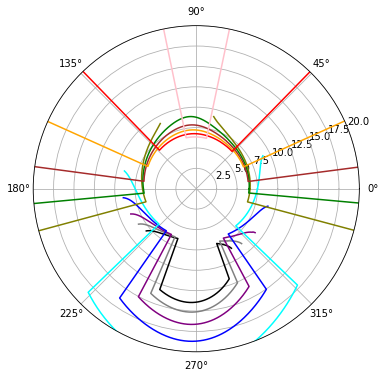

In [5]:
plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, constantf_180_30, color= 'black', label="$f=1.80$")
ax.plot(alphas, constantf_150_30, color= 'grey', label="$f=1.50$")
ax.plot(alphas, constantf_120_30, color= 'purple', label="$f=1.20$")
ax.plot(alphas, constantf_090_30, color= 'blue', label="$f=0.90$")
ax.plot(alphas, constantf_060_30, color= 'cyan', label="$f=0.60$")
ax.plot(alphas, constantf_030_30, color= 'olive', label="$f=0.30$")
ax.plot(alphas, constantf_025_30, color= 'green', label="$f=0.25$")
ax.plot(alphas, constantf_020_30, color= 'brown', label="$f=0.20$")
ax.plot(alphas, constantf_015_30, color= 'orange', label="$f=0.15$")
ax.plot(alphas, constantf_010_30, color= 'red', label="$f=0.10$")
ax.plot(alphas, constantf_005_30, color= 'pink', label="$f=0.05$")
ax.set_rlim(0,20)
plt.show()

In [ ]:
alphas = np.linspace(0, 2*np.pi, 1000)
constantf_180_10 = np.empty(1000)
constantf_150_10 = np.empty(1000)
constantf_120_10 = np.empty(1000)
constantf_090_10 = np.empty(1000)
constantf_060_10 = np.empty(1000)
constantf_030_10 = np.empty(1000)
constantf_025_10 = np.empty(1000)
constantf_020_10 = np.empty(1000)
constantf_015_10 = np.empty(1000)
constantf_010_10 = np.empty(1000)
constantf_005_10 = np.empty(1000)

for i in range(0,1000):
    constantf_180_10[i]= constantflux(4*np.pi/9, alphas[i], 1, 1.80, 3.001, 100, False, 0, 3.001, 20)
    constantf_150_10[i]= constantflux(4*np.pi/9, alphas[i], 1, 1.50, 3.001, 100, False, 0, 3.001, 20)
    constantf_120_10[i]= constantflux(4*np.pi/9, alphas[i], 1, 1.2, 3.001, 100, False, 0, 3.001, 20)
    constantf_090_10[i]= constantflux(4*np.pi/9, alphas[i], 1, 0.9, 3.001, 100, False, 0, 3.001, 20)
    constantf_060_10[i]= constantflux(4*np.pi/9, alphas[i], 1, 0.6, 3.001, 100, False, 0, 3.001, 20)
    constantf_030_10[i]= constantflux(4*np.pi/9, alphas[i], 1, 0.3, 3.001, 100, False, 0, 3.001, 20)
    constantf_025_10[i]= constantflux(4*np.pi/9, alphas[i], 1, 0.25, 3.001, 100, False, 0, 3.001, 20)
    constantf_020_10[i]= constantflux(4*np.pi/9, alphas[i], 1, 0.2, 3.001, 100, False, 0, 3.001, 20)
    constantf_015_10[i]= constantflux(4*np.pi/9, alphas[i], 1, 0.15, 3.001, 100, False, 0, 3.001, 20)
    constantf_010_10[i]= constantflux(4*np.pi/9, alphas[i], 1, 0.1, 3.001, 100, False, 0, 3.001, 20)
    constantf_005_10[i]= constantflux(4*np.pi/9, alphas[i], 1, 0.05, 3.001, 100, False, 0, 3.001, 20)
    
plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, constantf_180_10, color= 'black', label="$f=1.80$")
ax.plot(alphas, constantf_150_10, color= 'grey', label="$f=1.50$")
ax.plot(alphas, constantf_120_10, color= 'purple', label="$f=1.20$")
ax.plot(alphas, constantf_090_10, color= 'blue', label="$f=0.90$")
ax.plot(alphas, constantf_060_10, color= 'cyan', label="$f=0.60$")
ax.plot(alphas, constantf_030_10, color= 'olive', label="$f=0.30$")
ax.plot(alphas, constantf_025_10, color= 'green', label="$f=0.25$")
ax.plot(alphas, constantf_020_10, color= 'brown', label="$f=0.20$")
ax.plot(alphas, constantf_015_10, color= 'orange', label="$f=0.15$")
ax.plot(alphas, constantf_010_10, color= 'red', label="$f=0.10$")
ax.plot(alphas, constantf_005_10, color= 'pink', label="$f=0.05$")
plt.legend()
plt.show()

In [ ]:
print(1)